In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle

import os

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
# choose resolution

layer_spacing = 5e3
# layer_spacing = 10e3

grav_spacing = 5e3
# grav_spacing = 10e3

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    f"../inversion_layers/RIS_starting_prisms_{int(layer_spacing)}k_constraints.zarr"
)

# gravity data and anomalies
df_anomalies = pd.read_csv(
    "../data/RIS_residual_50k_filt_mask.csv.gz",
    # "../data/RIS_residual_50k_filt.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# set regions
buffer_region = utils.get_grid_info(starting_prisms.density)[1]
inversion_region = vd.get_region((df_anomalies.easting, df_anomalies.northing))

# set layer parameters
registration = utils.get_grid_info(starting_prisms.density)[4]

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# constraints
if layer_spacing == 5e3:
    constraints_fname = "../data/bed_constraints_5k.csv.gz"
elif layer_spacing == 10e3:
    constraints_fname = "../data/bed_constraints_10k.csv.gz"
else:
    raise ValueError("No constraint point files available at specified spacing!")

constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)
print(f"bathymetry control points:{len(constraints)}")

# starting bed
if layer_spacing == 5e3:
    fname = "../inversion_layers/bed_from_constraints_5k.zarr"
elif layer_spacing == 10e3:
    fname = "../inversion_layers/bed_from_constraints_10k.zarr"
else:
    raise ValueError("No bed grids available at specified spacing!")
bed_full = xr.open_zarr(fname).bed
bed = fetch.resample_grid(
    bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
icebase_full = xr.open_zarr(fname).icebase
icebase_layer_spacing = fetch.resample_grid(
    icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

constraints.head()

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


layer spacing: 5000.0m
registration: g
inversion region =  (-580000.0, 385000.0, -1385000.0, -445000.0)
buffer region =  [-620000.0, 460000.0, -1460000.0, -380000.0]
bathymetry control points:28087
spacing larger than original, filtering and resampling


,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type
24072,-1460000.0,-620000.0,-3613.190674,NaN,NaN,NaN,NaN,NaN,NaN
24073,-1460000.0,-615000.0,-3614.358154,NaN,NaN,NaN,NaN,NaN,NaN
24074,-1460000.0,-610000.0,-3607.669189,NaN,NaN,NaN,NaN,NaN,NaN
24075,-1460000.0,-605000.0,-3614.168213,NaN,NaN,NaN,NaN,NaN,NaN
24076,-1460000.0,-600000.0,-3645.910156,NaN,NaN,NaN,NaN,NaN,NaN


# Seperate constraints inside and outside of RIS

In [4]:
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS = RIS_seperate.dissolve()

gdf = gpd.GeoDataFrame(
    constraints,
    geometry=gpd.points_from_xy(x=constraints.easting, y=constraints.northing),
    crs="EPSG:3031",
)

constraints["inside"] = gdf.within(RIS.geometry[0])
constraints.drop(columns="geometry", inplace=True)
constraints.head()

,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type,inside
24072,-1460000.0,-620000.0,-3613.190674,NaN,NaN,NaN,NaN,NaN,NaN,False
24073,-1460000.0,-615000.0,-3614.358154,NaN,NaN,NaN,NaN,NaN,NaN,False
24074,-1460000.0,-610000.0,-3607.669189,NaN,NaN,NaN,NaN,NaN,NaN,False
24075,-1460000.0,-605000.0,-3614.168213,NaN,NaN,NaN,NaN,NaN,NaN,False
24076,-1460000.0,-600000.0,-3645.910156,NaN,NaN,NaN,NaN,NaN,NaN,False


In [5]:
# fig = maps.basemap(region=buffer_region,)

# fig.plot(RIS, pen="0.6p,black")

# fig.plot(
#     x=constraints[~constraints.inside].easting,
#     y=constraints[~constraints.inside].northing,
#     style="c0.05c",
#     fill="blue",
# )

# fig.plot(
#     x=constraints[constraints.inside].easting,
#     y=constraints[constraints.inside].northing,
#     style="c0.1c",
#     fill="red",
# )

# fig.show()

In [6]:
# df = constraints[constraints.inside].copy()
# blocks, labels = vd.block_split(
#     (df.easting, df.northing),
#     spacing=100e3,
#     # shape = (5,5),
# )
# df['block_label']=labels
# df

In [7]:
# fig = maps.basemap(
#     region=buffer_region,
#     coast=True,
# )

# for x, y in zip(blocks[0], blocks[1]):
#     fig.plot(
#         x = x,
#         y = y,
#         style="c0.3c",
#         fill="red",
#     )

# fig.show()

# Split inside constraints into `Training` and `Testing`
Avoid spatial bias by using spatial blocks implemented with `verde.BlockKFold`.

In [8]:
constraints[constraints.inside]

,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type,inside
103972,-1.290527e+06,291621.051176,-921.0,-77.86667,167.2667,1.0,NaN,NaN,NaN,True
103973,-1.290120e+06,287588.704471,-925.0,-77.87833,167.4333,1.0,NaN,NaN,NaN,True
103974,-6.990059e+05,85734.253520,-1159.0,-83.52500,173.0075,19.0,NaN,NaN,NaN,True
103975,-1.291101e+06,295701.649410,-698.0,-77.85333,167.1000,1.0,NaN,NaN,NaN,True
103976,-1.291204e+06,297701.548871,-627.0,-77.84834,167.0167,1.0,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...
104190,-8.164639e+05,-218050.118799,-564.0,-82.23361,-165.0472,19.0,NaN,NaN,NaN,True
104191,-1.087485e+06,-452466.872984,-714.0,-79.19028,-157.4094,19.0,NaN,NaN,NaN,True
104192,-1.033177e+06,-214445.845201,-512.0,-80.31055,-168.2742,19.0,NaN,NaN,NaN,True
104193,-8.266453e+05,-197189.312136,-583.0,-82.19000,-166.5833,1.0,NaN,NaN,NaN,True


In [9]:
constraints

,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type,inside
24072,-1.460000e+06,-620000.000000,-3613.190674,NaN,NaN,NaN,NaN,NaN,NaN,False
24073,-1.460000e+06,-615000.000000,-3614.358154,NaN,NaN,NaN,NaN,NaN,NaN,False
24074,-1.460000e+06,-610000.000000,-3607.669189,NaN,NaN,NaN,NaN,NaN,NaN,False
24075,-1.460000e+06,-605000.000000,-3614.168213,NaN,NaN,NaN,NaN,NaN,NaN,False
24076,-1.460000e+06,-600000.000000,-3645.910156,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...
104190,-8.164639e+05,-218050.118799,-564.000000,-82.23361,-165.0472,19.0,NaN,NaN,NaN,True
104191,-1.087485e+06,-452466.872984,-714.000000,-79.19028,-157.4094,19.0,NaN,NaN,NaN,True
104192,-1.033177e+06,-214445.845201,-512.000000,-80.31055,-168.2742,19.0,NaN,NaN,NaN,True
104193,-8.266453e+05,-197189.312136,-583.000000,-82.19000,-166.5833,1.0,NaN,NaN,NaN,True


In [10]:
test_train_df = inv_utils.split_constraints_test_train(
    constraints,
    spacing=1e3,
    # shape = (10,10),
    n_splits=223,
    test_size=1,
    # plot=True,
    # number_to_plot = 2,
)
print(f"Test points in fold 0: {len(test_train_df[test_train_df.fold_0==' test'])}")
test_train_df

Test points in fold 0: 1


,northing,easting,upward,lat,lon,station_ID,z_geoidal,z_error,measurement_type,inside,...,fold_213,fold_214,fold_215,fold_216,fold_217,fold_218,fold_219,fold_220,fold_221,fold_222
103972,-1.290527e+06,291621.051176,-921.000000,-77.86667,167.2667,1.0,NaN,NaN,NaN,True,...,train,train,train,train,train,train,train,train,train,train
103973,-1.290120e+06,287588.704471,-925.000000,-77.87833,167.4333,1.0,NaN,NaN,NaN,True,...,train,train,train,train,train,train,train,train,train,test
103974,-6.990059e+05,85734.253520,-1159.000000,-83.52500,173.0075,19.0,NaN,NaN,NaN,True,...,train,train,train,train,train,train,train,train,train,train
103975,-1.291101e+06,295701.649410,-698.000000,-77.85333,167.1000,1.0,NaN,NaN,NaN,True,...,train,train,train,train,train,train,train,train,train,train
103976,-1.291204e+06,297701.548871,-627.000000,-77.84834,167.0167,1.0,NaN,NaN,NaN,True,...,train,train,train,train,train,train,train,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81307,-3.800000e+05,440000.000000,-349.871338,NaN,NaN,NaN,NaN,NaN,NaN,False,...,train,train,train,train,train,train,train,train,train,train
81308,-3.800000e+05,445000.000000,-353.288727,NaN,NaN,NaN,NaN,NaN,NaN,False,...,train,train,train,train,train,train,train,train,train,train
81309,-3.800000e+05,450000.000000,-365.260284,NaN,NaN,NaN,NaN,NaN,NaN,False,...,train,train,train,train,train,train,train,train,train,train
81310,-3.800000e+05,455000.000000,-399.157166,NaN,NaN,NaN,NaN,NaN,NaN,False,...,train,train,train,train,train,train,train,train,train,train


# Setup Cross-validation with constarints
* split constraints within RIS into `training` and `testing` groups
* all constraints outside RIS are `training`
* run full inversion with `training` constraints
* compare `testing` elevations with resulting bathymetry, RMSE is the score


In [11]:
# load dataframe which has all the forward gravities
grav = pd.read_csv(
    "../data/RIS_bouguer_corrections_50k_filt_mask.csv.gz",
    # "../data/RIS_bouguer_corrections_50k_filt.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

anomaly_args = {
    "input_grav": grav,
    "input_forward_column": "bed_forward",
    "input_grav_column": "Gobs_corr",
    "regional_method": "constraints",
    "grav_spacing": grav_spacing,
    "inversion_region": inversion_region,
    "tension_factor": 0.25,
}

weights_args = {
    "inner_bound": 5e3,
    "outer_bound": 20e3,
    "low": 0,
    "high": 1,
    "region": inversion_region,
    "interp_type": "spline",
    "efficient_interp": True,
}

inversion_args = {
    "input_grav_column": "Gobs_corr_shift",
    "apply_weights": True,
    "max_iterations": 10,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 0.8,
    "perc_increase_limit": 0.2,
    "upper_confining_layer": icebase_layer_spacing,
    "deriv_type": "annulus",
    "solver_type": "scipy least squares",
    "solver_damping": 0.1,
}

# get list of folds
folds = list(test_train_df.columns[test_train_df.columns.str.startswith("fold_")])


# # create / overwrite files to store results in
# with open("../data/CV_constraints_scores", "wb") as fp:
#     pass
# with open("../data/CV_constraints_results", "wb") as fp:
#     pass
# with open("../data/CV_constraints_topos", "wb") as fp:
#     pass

# # for each fold, run inversion and record scores, inversion results, and final topography
# for i, f in enumerate(folds):
#     with inv_utils.HiddenPrints():
#         score, result, topo = inv_utils.inversion_cross_val_score(
#             test_train_df[test_train_df[f]==" test"],
#             test_train_df[test_train_df[f]=="train"],
#             starting_prisms,
#             anomaly_args,
#             weights_args,
#             inversion_args,
#         )
#     #rename grid with fold number
#     topo = topo.rename(f"fold_{i}")

#     # append new results to pickle files
#     with open("../data/CV_constraints_scores", "ab") as file:
#         pickle.dump(score, file, protocol=pickle.HIGHEST_PROTOCOL)
#     with open("../data/CV_constraints_results", "ab") as file:
#         pickle.dump(result, file, protocol=pickle.HIGHEST_PROTOCOL)
#     with open("../data/CV_constraints_topos", "ab") as file:
#         pickle.dump(topo, file, protocol=pickle.HIGHEST_PROTOCOL)

#     print(f"Score for fold # {i}: {score}")

grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).


Score for fold # 0: 61.392208254000025


grdtrack [WARNING]: Some input points were outside the grid domain(s).


KeyboardInterrupt: 

In [13]:
# reload results from pickle files
scores = []
with open("../data/CV_constraints_scores", "rb") as file:
    while 1:
        try:
            scores.append(pickle.load(file))
        except EOFError:
            break
results = []
with open("../data/CV_constraints_results", "rb") as file:
    while 1:
        try:
            results.append(pickle.load(file))
        except EOFError:
            break
topos = []
with open("../data/CV_constraints_topos", "rb") as file:
    while 1:
        try:
            topos.append(pickle.load(file))
        except EOFError:
            break
len(scores)

223

In [14]:
np.mean(scores)

60.925211656995515

# Setup Bootstrap analysis
* systematically exclude RIS constraint points
* run inversion lots of times with subset constraints
* calculate standard deviation of each grid cell 

In [18]:
# final inverted bathymetry model
fname = "../results/weights_mask_prism_results.csv.gz"
inverted_bathy = pd.read_csv(
    fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
inverted_bathy = inverted_bathy.set_index(["northing", "easting"]).to_xarray()[
    inverted_bathy.columns[-1]
]

In [15]:
# merge topo grids into a dataset
final_topos = xr.merge(topos)

# merge variables into a single variable with a new axis "folds"
variables = list(final_topos)
ds_merged = (
    xr.concat([final_topos[var] for var in variables], dim="folds")
    .assign_coords({"folds": variables})
    .rename("fold_num")
    .to_dataset()
)
ds_merged

<xarray.Dataset>
Dimensions:   (northing: 217, easting: 217, folds: 223)
Coordinates:
  * northing  (northing) float64 -1.46e+06 -1.455e+06 ... -3.85e+05 -3.8e+05
  * easting   (easting) float64 -6.2e+05 -6.15e+05 -6.1e+05 ... 4.55e+05 4.6e+05
  * folds     (folds) <U8 'fold_0' 'fold_1' 'fold_2' ... 'fold_221' 'fold_222'
Data variables:
    fold_num  (folds, northing, easting) float64 -3.613e+03 ... -431.6

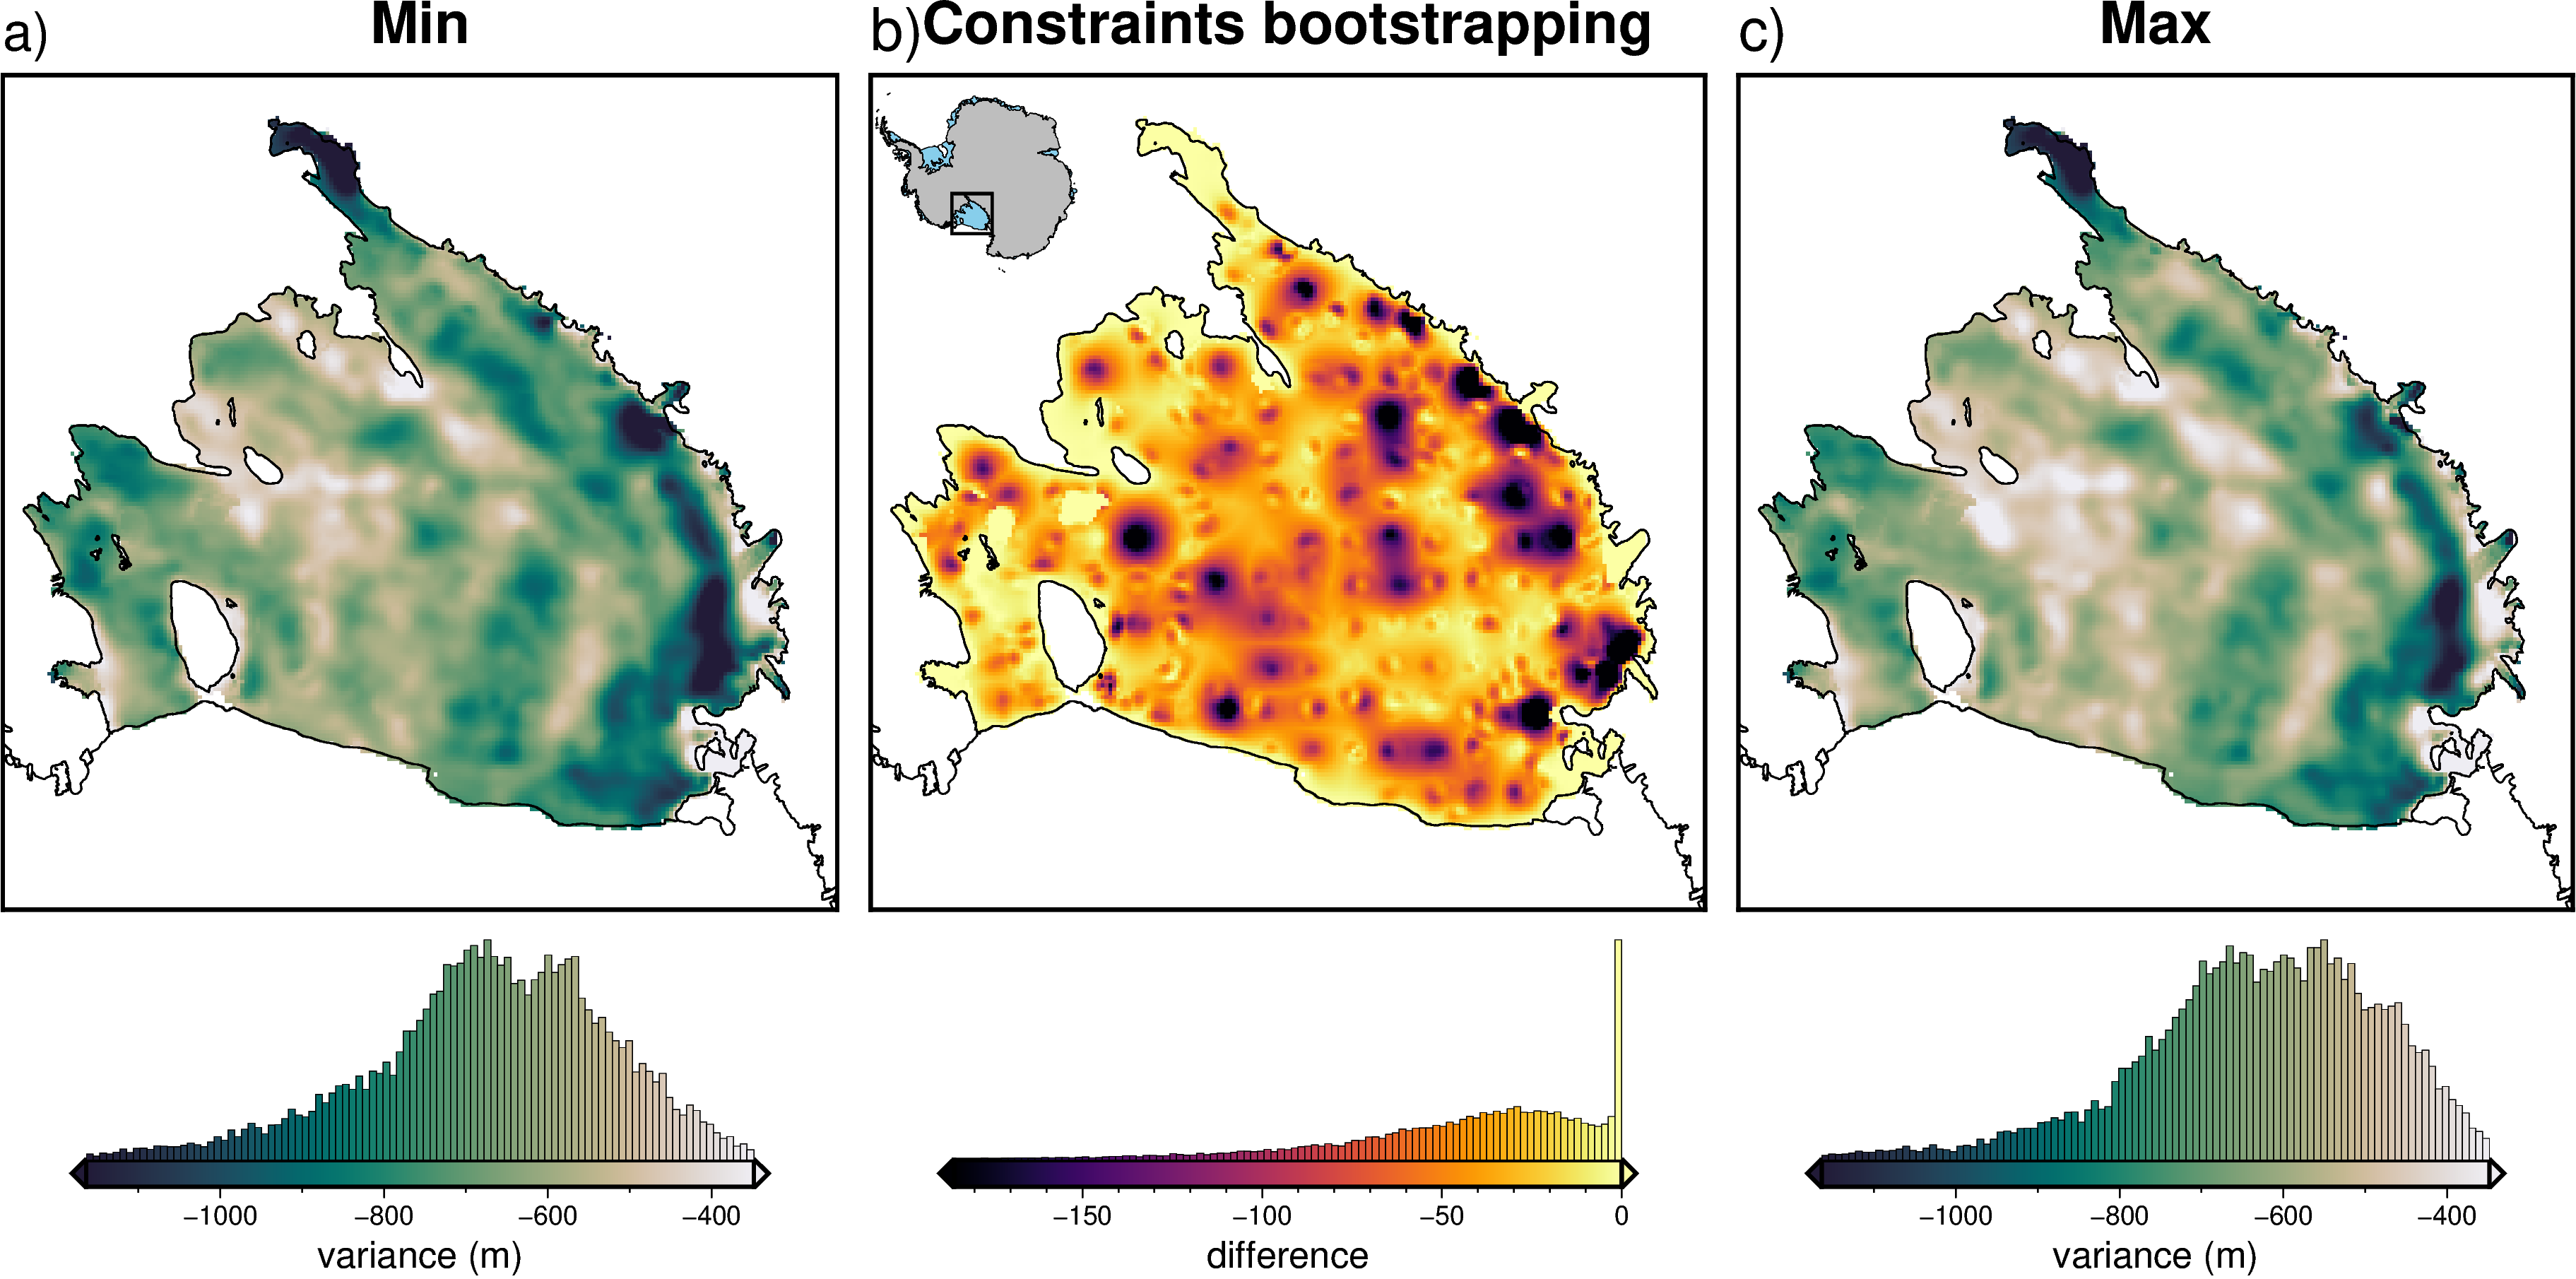

In [21]:
merged_min = ds_merged["fold_num"].min("folds")
merged_max = ds_merged["fold_num"].max("folds")
merged_min = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=merged_min,
    masked=True,
    invert=False,
)
merged_max = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=merged_max,
    masked=True,
    invert=False,
)

_ = utils.grd_compare(
    merged_min,
    merged_max,
    plot=True,
    grid1_name="Min",
    grid2_name="Max",
    title="Constraints bootstrapping",
    cbar_label="variance (m)",
    diff_cmap="inferno",
    diff_maxabs=False,
    cmap="rain",
    reverse_cpt=True,
    rmse_in_title=False,
    subplot_labels=True,
    robust=True,
    hist=True,
    # shp_mask="../plotting/RIS_outline.shp",
)

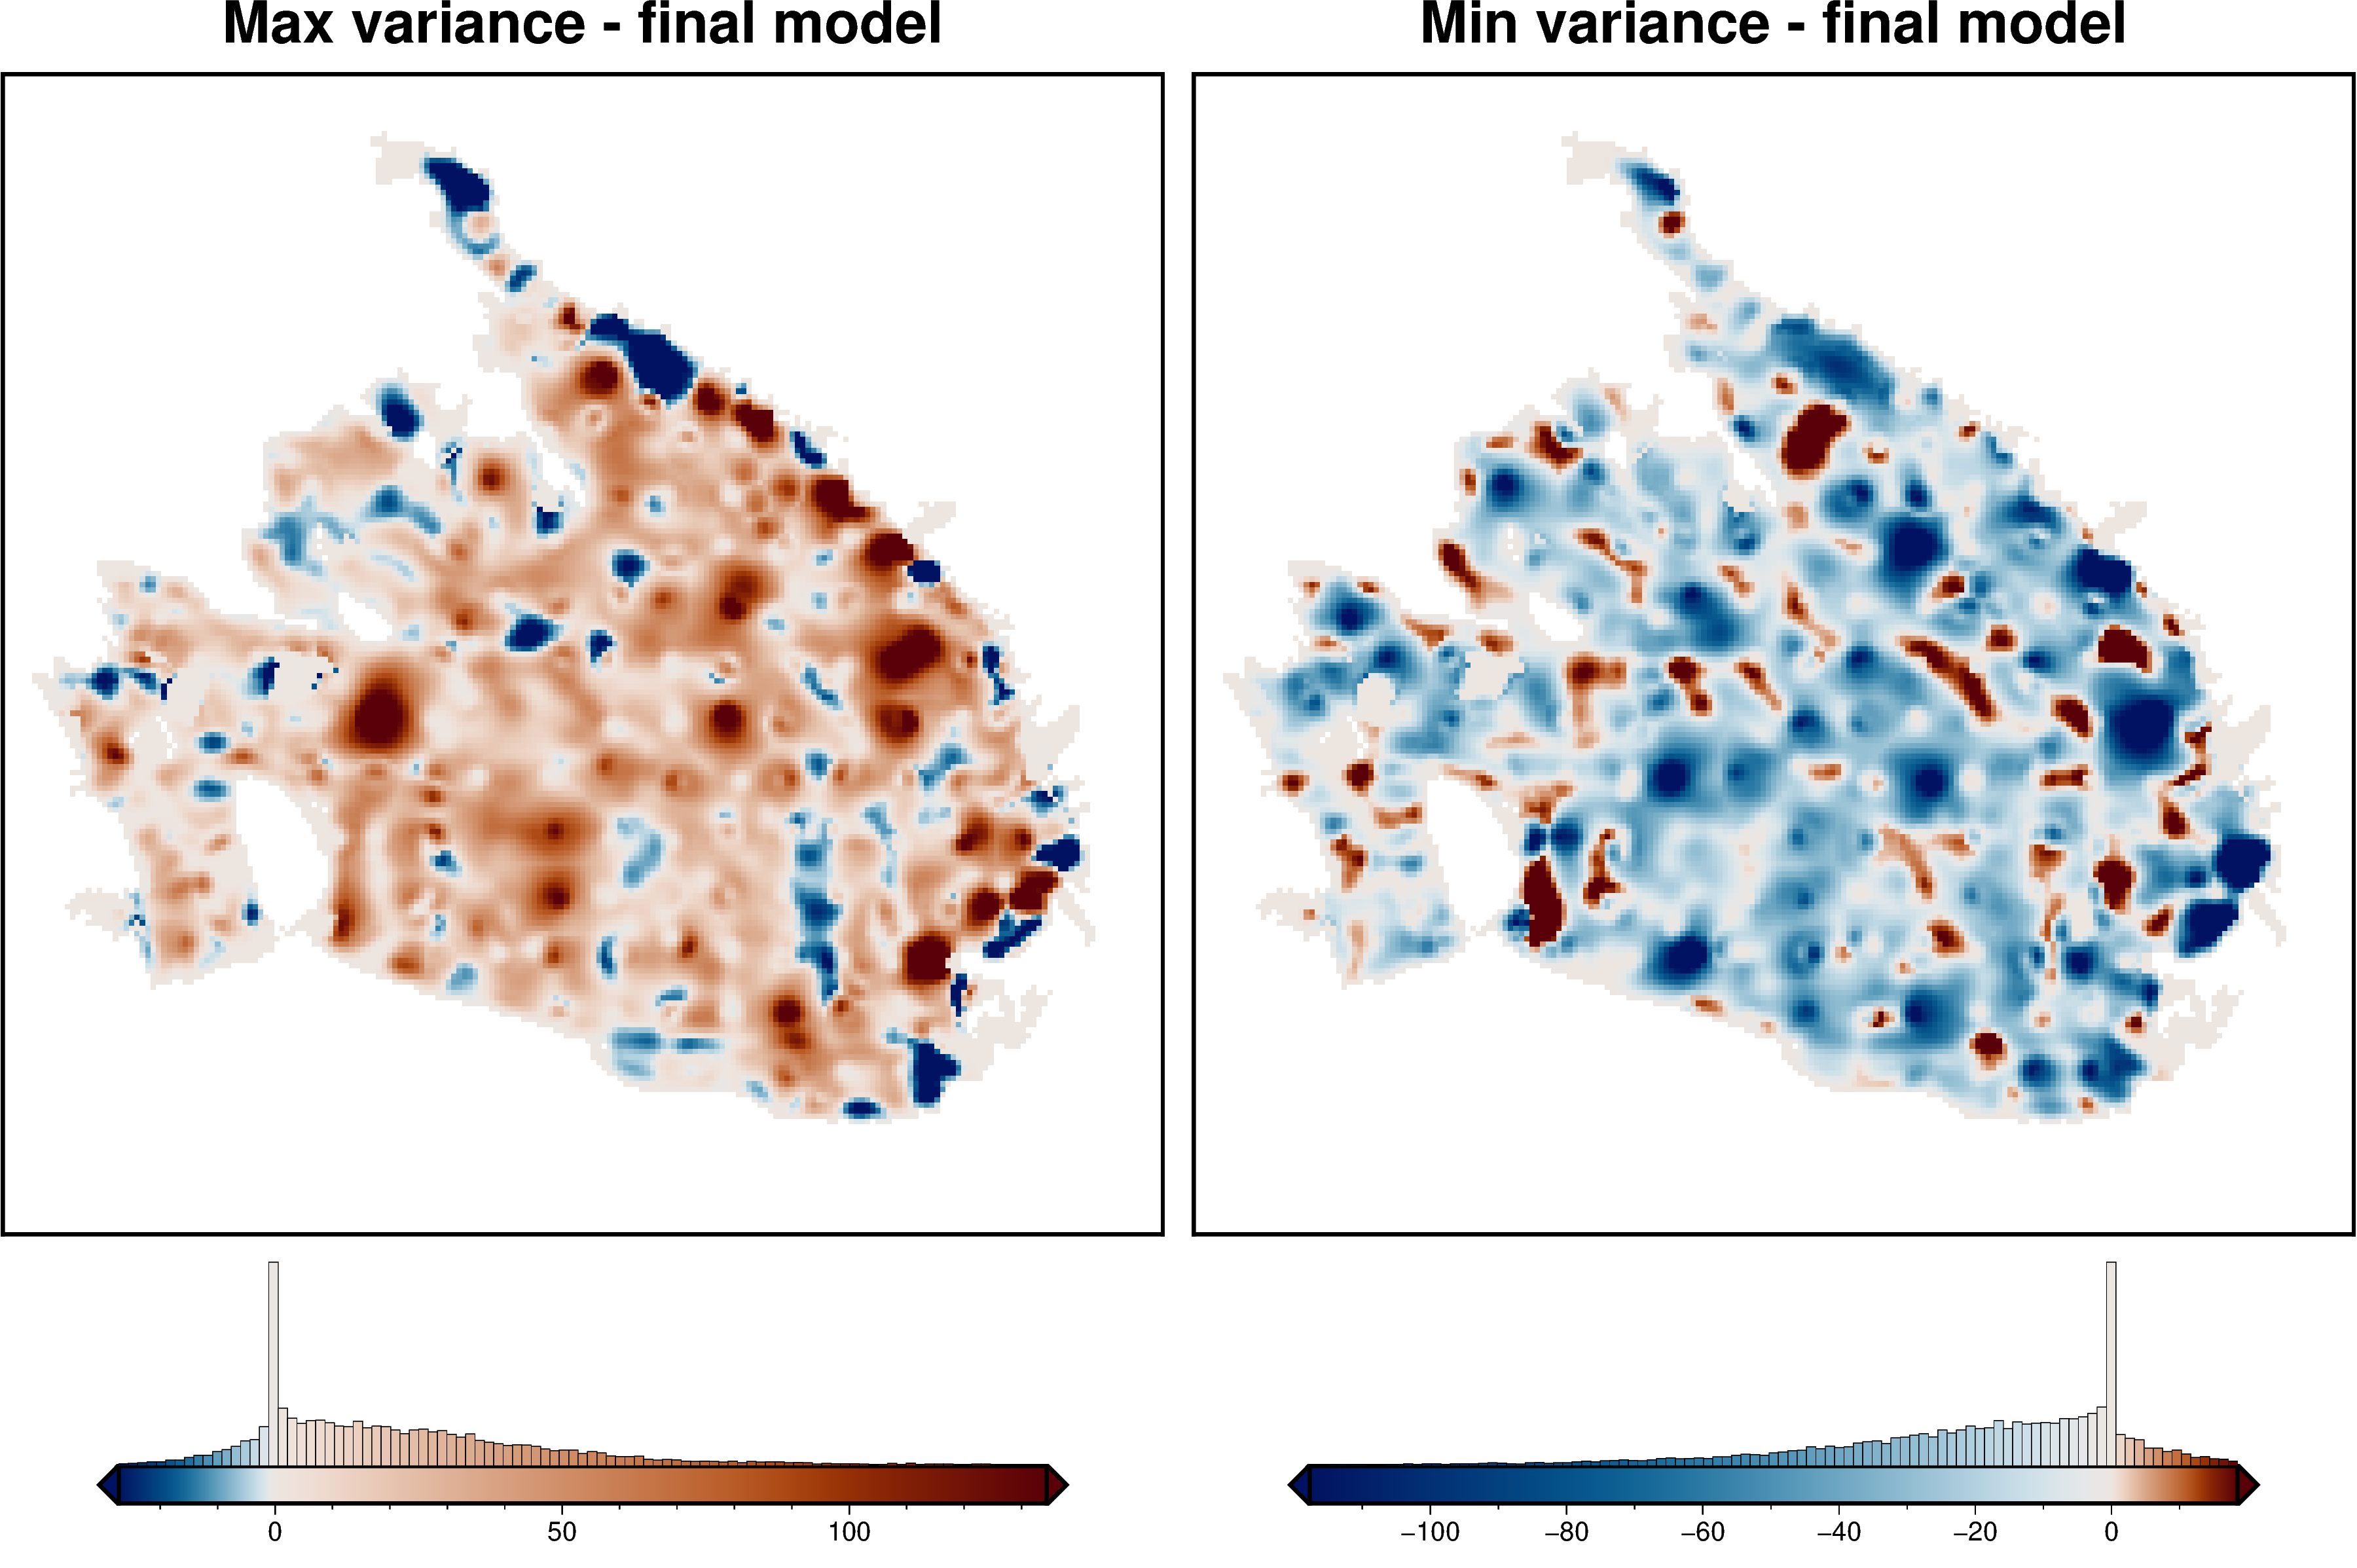

In [20]:
inverted_bathy_mask = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp",
    xr_grid=inverted_bathy,
    masked=True,
    invert=False,
)
max_to_final = merged_max - inverted_bathy_mask
min_to_final = merged_min - inverted_bathy_mask

fig = maps.plot_grd(
    max_to_final,
    title="Max variance - final model",
    cmap="vik+h0",
    robust=True,
    hist=True,
)
fig = maps.plot_grd(
    min_to_final,
    title="Min variance - final model",
    cmap="vik+h0",
    robust=True,
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

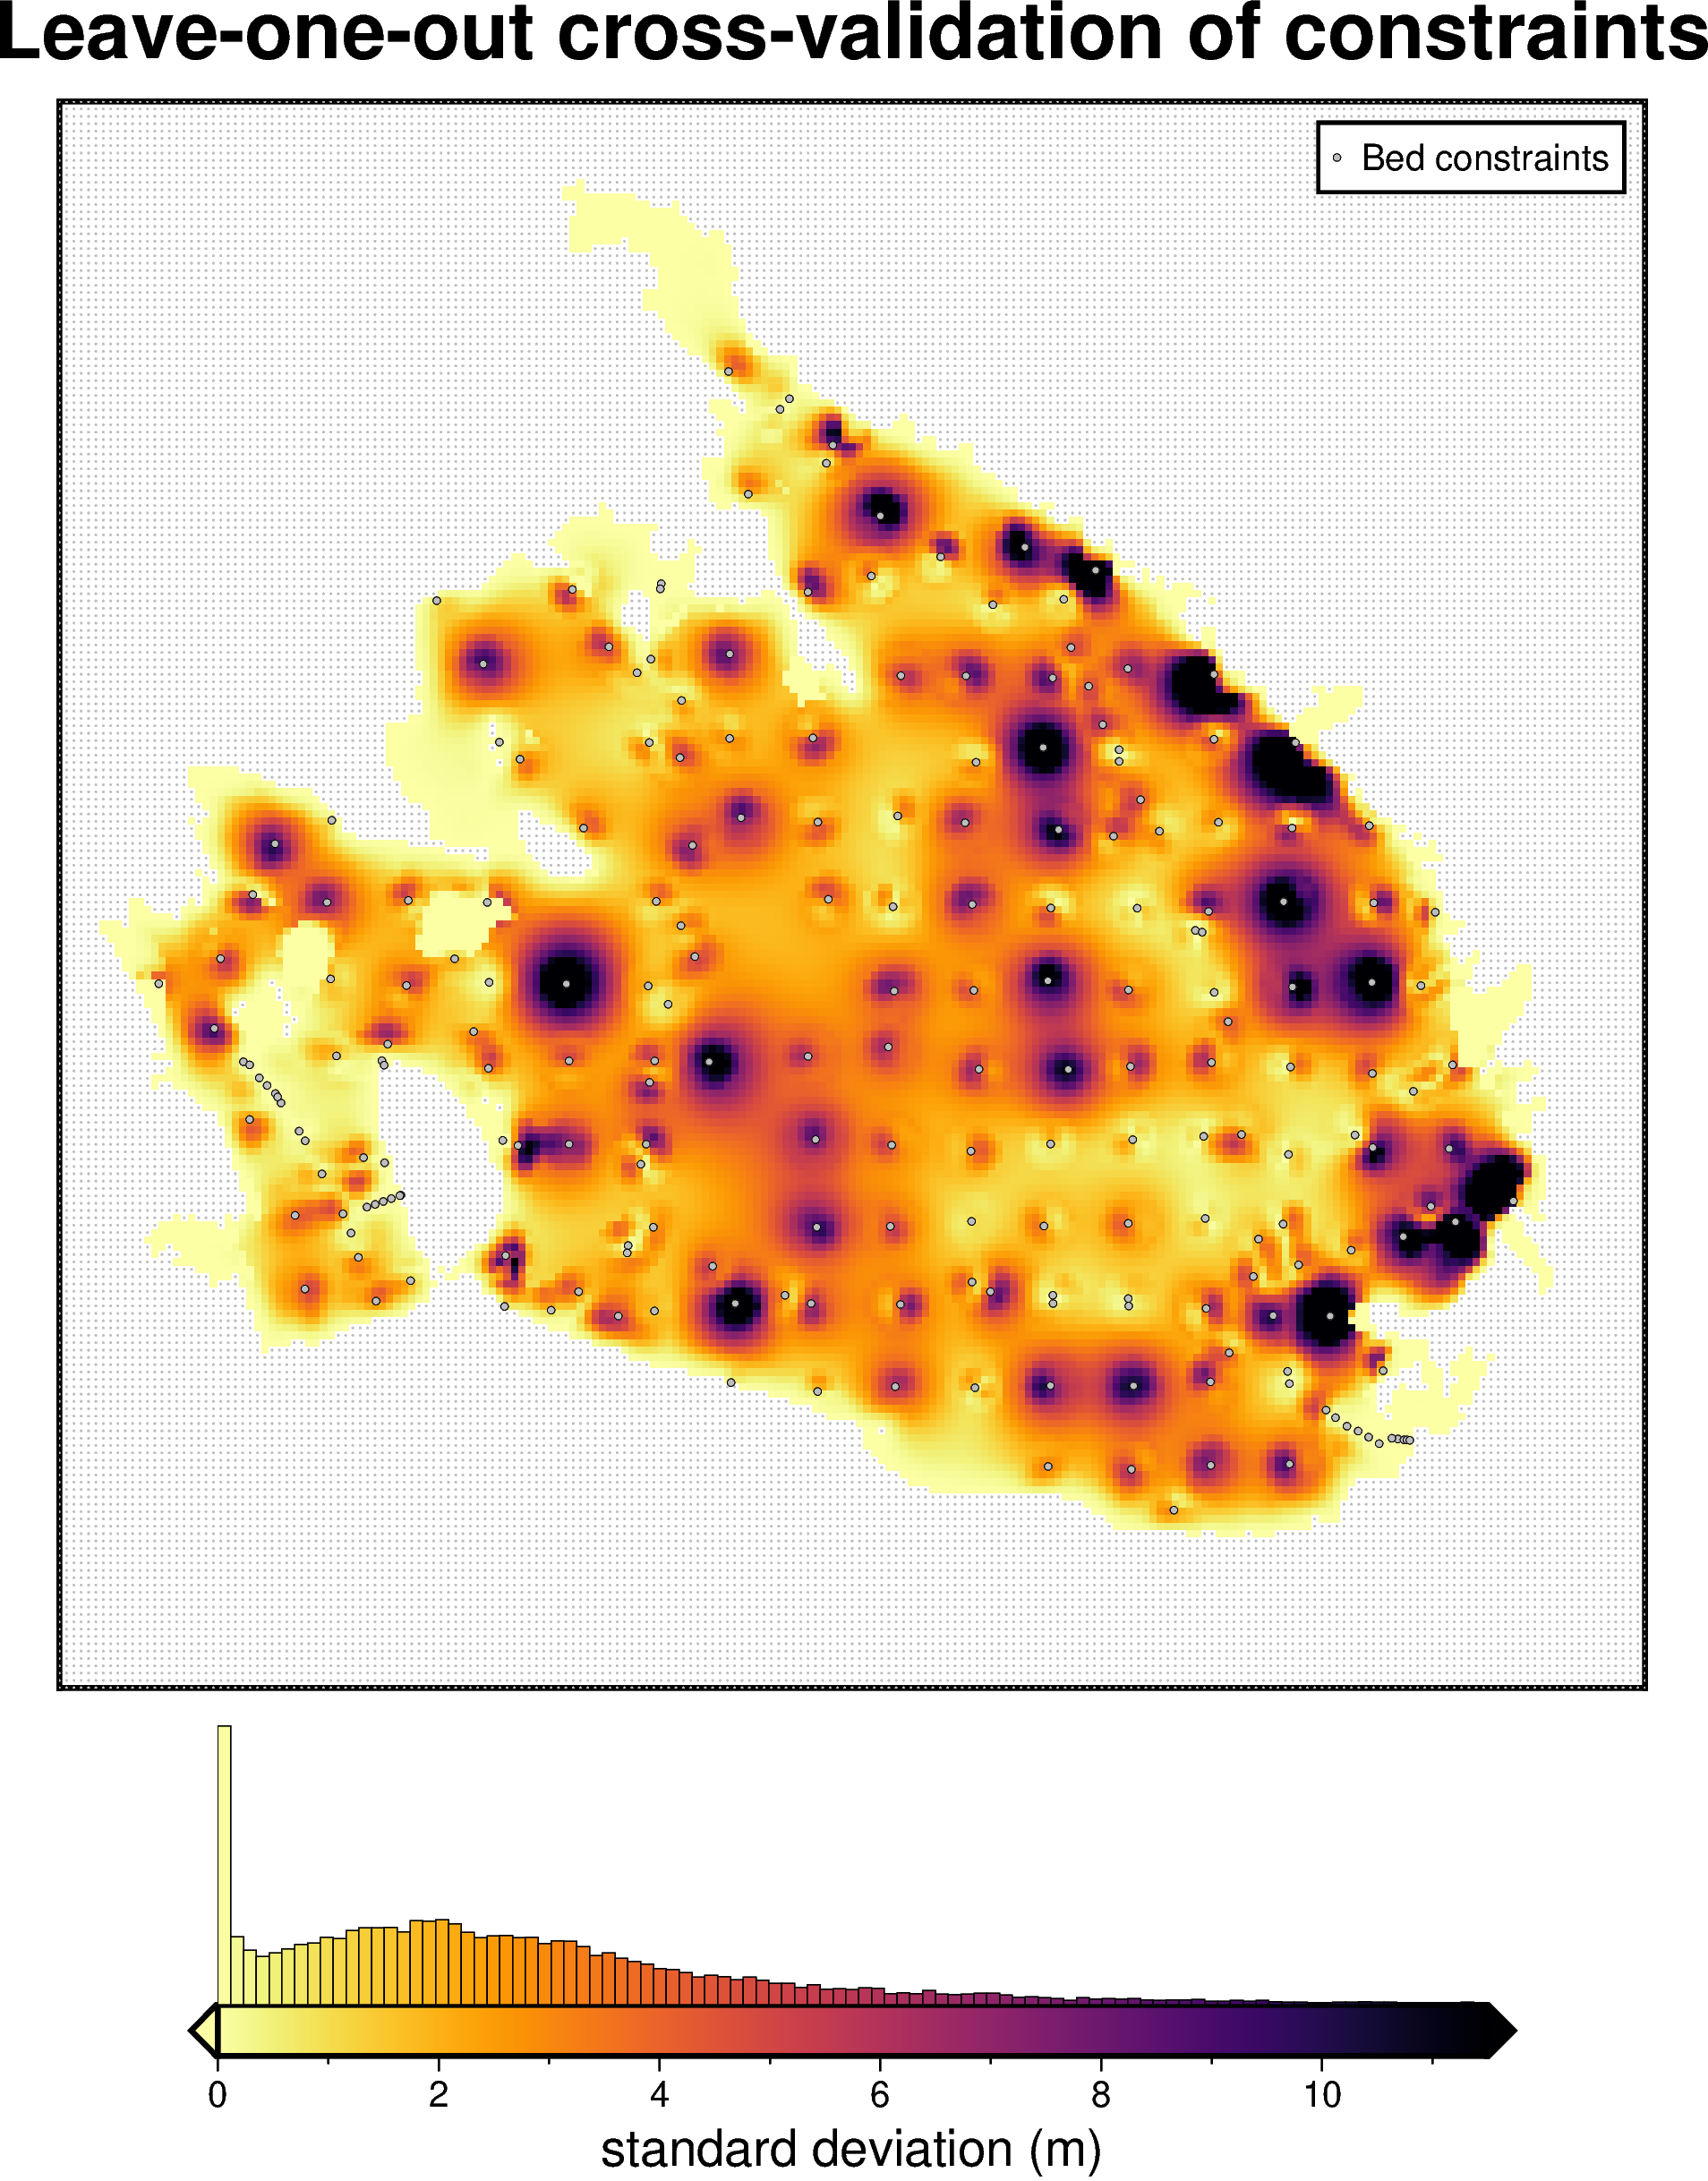

In [23]:
stdev = ds_merged["fold_num"].std("folds").rename("stdev")
stdev = utils.mask_from_shp(
    shapefile="../plotting/RIS_outline.shp", xr_grid=stdev, masked=True, invert=False
)

fig = maps.plot_grd(
    stdev,
    cmap="inferno",
    reverse_cpt=True,
    robust=True,
    hist=True,
    cbar_label="standard deviation (m)",
    title='"Leave-one-out" cross-validation of constraints',
)

fig.plot(
    x=constraints.easting,
    y=constraints.northing,
    fill="gray",
    style="c.02c",
)
fig.plot(
    x=constraints[constraints.inside].easting,
    y=constraints[constraints.inside].northing,
    fill="gray",
    pen=".1p,black",
    style="c.07c",
    label="Bed constraints",
)
fig.legend()

fig.show()

# Run inversion

In [60]:
# results_weights_in_jac = inv.geo_inversion(
#     input_grav=df_anomalies,
#     input_grav_column="Gobs_corr_shift",
#     prism_layer=starting_prisms,
#     apply_weights = True,
#     # apply_weights = False,
#     weights_after_solving = False,

#     max_iterations=5,
#     l2_norm_tolerance=.2, #0.01, #.2,
#     delta_l2_norm_tolerance=.8, #.1, #.8,
#     perc_increase_limit= .2,# 1000, #.2,
#     upper_confining_layer=icebase_layer_spacing,

#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 0.01,

#     # save_results=True,
#     # fname_prefix= "results/weights_mask",
#         )

# Plot results

In [ ]:
# prism_results, grav_results, params, elapsed_time = results
# # prism_results = "../results/weights_no_mask_prism_results.csv.gz"
# # grav_results = "../results/weights_no_mask_gravity_results.csv.gz"
# # params = "../results/weights_no_mask_parameters.npy"

# with_weights_grids = plotting.plot_inversion_results(
#     grav_results,
#     prism_results,
#     params,
#     grav_region=inversion_region,
#     grav_spacing=layer_spacing,
#     constraints=constraints,
#     # plot_iter_results=False
#     # plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=2,
#     shp_mask = "../plotting/RIS_outline.shp",
#     misfit_cmap_perc=.2,
#     topo_cmap_perc=.8,
#     corrections_cmap_perc=.2,
#     )
# with_weights_final_topo = with_weights_grids[1][-1]
# with_weights_topo_diff = bed.rename({"x":"easting","y":"northing"}) - with_weights_final_topo